In [1]:
import os
import pandas as pd
import copernicusmarine
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns
from pandas.plotting import scatter_matrix

sns.set_style("whitegrid")

## Datasets

Importing datasets from we have discussed from copernicus 

In [2]:
dataset_ox = copernicusmarine.open_dataset(dataset_id ="cmems_mod_glo_bgc-bio_anfc_0.25deg_P1M-m")
dataset_chl = copernicusmarine.open_dataset(dataset_id = 'cmems_mod_glo_bgc-pft_anfc_0.25deg_P1M-m')
dataset_chm = copernicusmarine.open_dataset(dataset_id = 'cmems_mod_glo_bgc-nut_anfc_0.25deg_P1M-m')

INFO - 2024-07-31T18:08:41Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-07-31T18:08:41Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-07-31T18:08:47Z - Service was not specified, the default one was selected: "arco-geo-series"
INFO - 2024-07-31T18:08:58Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-07-31T18:08:58Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-07-31T18:09:05Z - Service was not specified, the default one was selected: "arco-geo-series"
INFO - 2024-07-31T18:09:16Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-07-31T18:09:16Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-07-31T18:09:25Z - Service was not specified, the default one was selected: "arco-geo-series"


Slicing for a `month` and `latitude`,`longitude` (for simplicity just a month and small area) 

In [3]:
ds_ox = dataset_ox.sel(time = slice('2022-07-01', '2022-07-02'),latitude = slice(53, 56.0),longitude = slice(2.5,9.25), depth = slice(0,2.521141e+01))
ds_chl = dataset_chl.sel(time = slice('2022-07-01', '2022-07-02'),latitude = slice(53, 56.0),longitude = slice(2.5,9.25),depth = slice(0,2.521141e+01))
ds_chm = dataset_chm.sel(time = slice('2022-07-01', '2022-07-02'), latitude = slice(53, 56.0),longitude = slice(2.5,9.25),depth = slice(0,2.521141e+01))

 Combining all into a single dataset by coordinates `['latitude','longitude',"time",'depth']`. I dropped `NaNs`.

In [4]:
combined_ds = xr.combine_by_coords([ds_ox, ds_chl, ds_chm ], coords=['latitude','longitude',"time",'depth']
                                , join="inner",combine_attrs = 'drop_conflicts')

Export to pandas (note that this takes some time)

In [5]:
pd_df = combined_ds.to_dataframe().dropna().reset_index()
# pd_df.to_csv("out.csv") turn this on to save the  into local

## Plots

First, the scatter plots for between all variables of the dataset (for a fixed `depth`). Here we see relation between `chl`-`phyc` is nearly perfect linear, (probably because one of them is derived from the other ?) so we are not going to use `phyc` as a feature. Also the its interesting to see the functional realtion between `po4`-`si`, `po4`-`fe`.

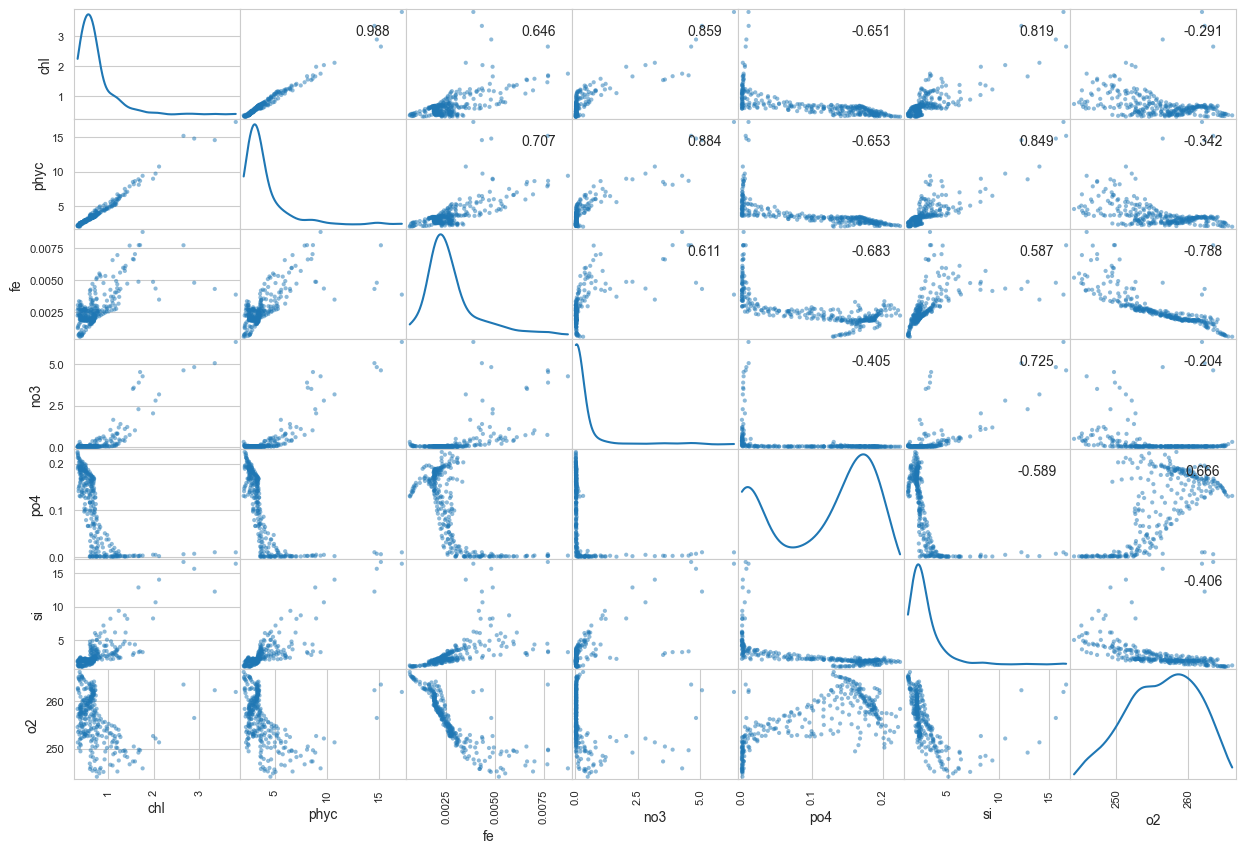

In [6]:
pd_df_0 = pd_df.loc[pd_df['depth']== pd_df['depth'][0] ]
axes = scatter_matrix(pd_df_0[['chl','phyc','fe', 'no3', 'po4','si','o2']], alpha=0.5,figsize=(15, 10), diagonal='kde')
corr = pd_df_0[['chl','phyc','fe', 'no3', 'po4','si','o2']].corr().to_numpy()
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')
plt.show()

One other potential plot of interest is a pairplot, here I plotted `chl` vs other features using `hue = 'depth'`

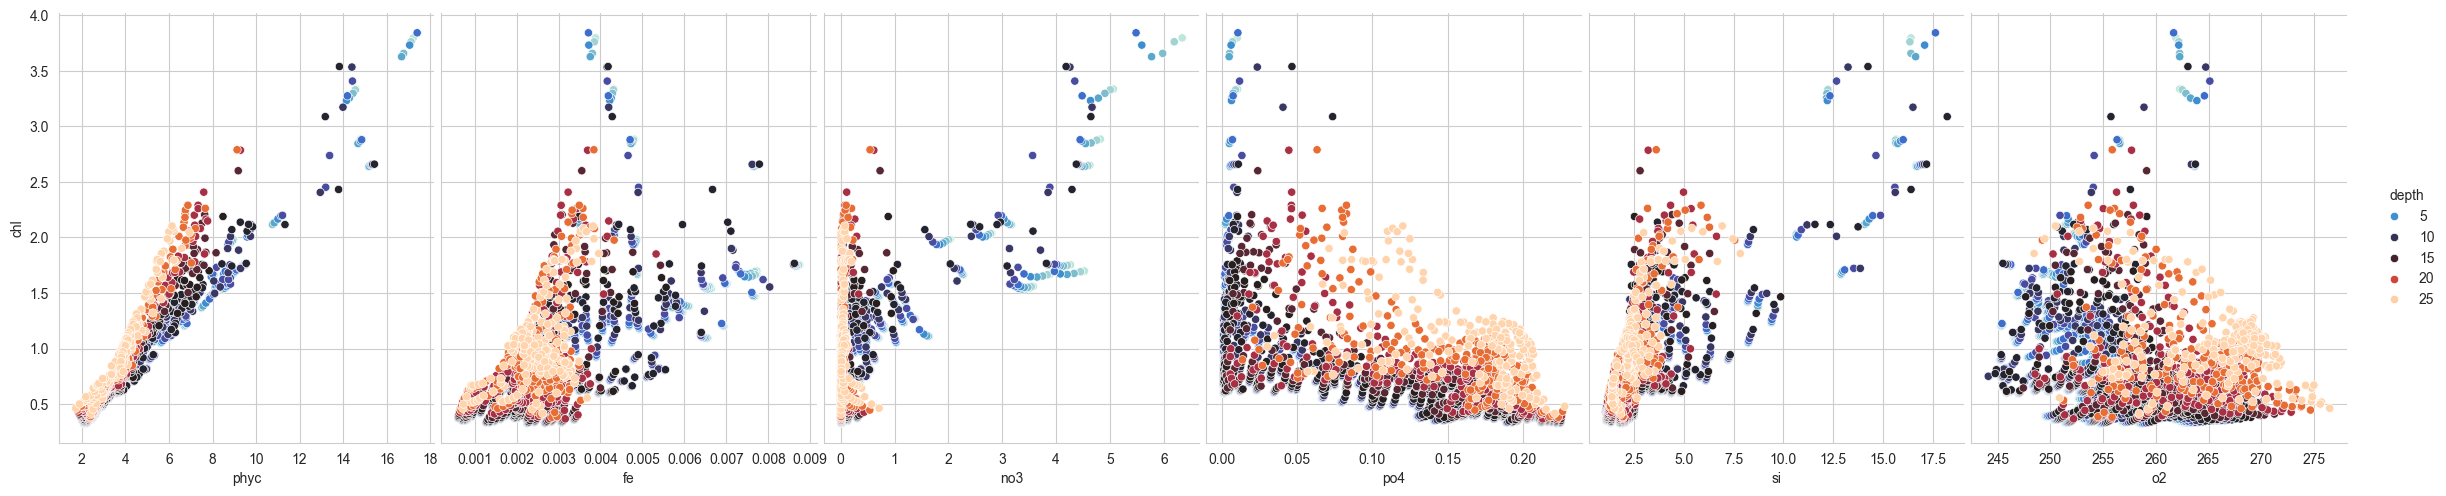

In [7]:
sns.pairplot(
                data= pd_df,
                x_vars=['phyc','fe', 'no3', 'po4','si','o2'],
                y_vars=['chl'],hue = 'depth',palette='icefire'
            , height=5, aspect=0.8)
plt.show()

## Some simple models

In [8]:
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Lasso regression

We start with the Lasso and see the feature importance for the feature set. For this first create train-test split using the feature set `['fe', 'no3', 'po4', 'si', 'nppv', 'o2']`. Note that we threw away `phyc`.

In [9]:
chl_train, chl_test = train_test_split(pd_df.copy(), shuffle = True, test_size = .8,random_state= 131)
features = chl_train.columns[6:].to_list()
features

['fe', 'no3', 'po4', 'si', 'nppv', 'o2']

In [10]:
alphas = [0.00001,0.0001,0.001,0.005,0.0075,0.01,0.015,0.05,0.1,1,10,100,1000] # Lasso coefficients
                

## make coefficient holder
coefs = np.zeros((len(alphas), len(features)))

## scale quantitative variables
chl_train_array = chl_train[features].to_numpy()

scaler = StandardScaler()

## The features that need to be scaled
scale_columns = np.arange(len(features))
chl_train_array_scaled = chl_train_array.copy()
chl_train_array_scaled[:,scale_columns] = scaler.fit_transform(chl_train_array_scaled[:,scale_columns])


## Loop through alphas
for i in range(len(alphas)):
    ## make lasso model
    lasso = Lasso(alpha=alphas[i], max_iter=10000000)
    
    
    ## fit model
    lasso.fit(chl_train_array_scaled, chl_train.chl.values)
    
    ## record coefs
    coefs[i,:] = lasso.coef_

df_lass = pd.DataFrame(data=coefs, index=alphas, columns=features) # a table for the Lasso coefficients
df_lass    

,fe,no3,po4,si,nppv,o2
0.00001,0.228925,-0.064136,-0.134522,0.113690,0.206947,0.263202
0.00010,0.228157,-0.063176,-0.134509,0.113342,0.206583,0.262473
0.00100,0.220643,-0.053668,-0.134302,0.109768,0.203031,0.255221
0.00500,0.187193,-0.011544,-0.133249,0.093992,0.187343,0.222904
0.00750,0.172972,-0.000000,-0.129326,0.089839,0.184184,0.206721
0.01000,0.163886,-0.000000,-0.122881,0.090235,0.186174,0.193659
0.01500,0.145746,0.000000,-0.109997,0.090999,0.190160,0.167552
0.05000,0.026661,0.005308,-0.027908,0.093427,0.211494,0.000000
0.10000,0.008210,0.000000,-0.006304,0.089669,0.188299,0.000000
1.00000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000


From the Lasso coefficient table we find the first value of `alpha` where the parameter for the feature was set to zero. 

In [11]:
print(df_lass.ne(0).idxmin().sort_values(ascending=False))

fe      1.0000
po4     1.0000
si      1.0000
nppv    1.0000
o2      0.0500
no3     0.0075
dtype: float64


### Linear Regression

In [12]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

Below `powerset()` function will create all possible subset of the features and then we apply linear regression on them to see which model has the lowest cross-validation mse.

In [13]:
# This returns the power set of a set minus the empty set
def powerset(s):
    power_set = []
    x = len(s)
    for i in range(1 << x):
        power_set.append([s[j] for j in range(x) if (i & (1 << j))])
        
    return power_set[1:]

In [14]:
kfold = KFold(n_splits=5, 
              shuffle=True, 
              random_state = 186)

In [15]:
## get all models we're interested in
models = powerset(features)


## This is the baseline model
models.append("baseline")


## make empty mse holder
cv_rmses = np.zeros((5, len(models)))



## loop through all splits
i = 0
for train_index, test_index in kfold.split(chl_train):
    ## get train and holdout sets
    chl_train_train = chl_train.iloc[train_index]
    chl_holdout = chl_train.iloc[test_index]


    ## loop through all models
    j = 0
    for model in models:
        if model == "baseline":
            chl_train_train_mean = chl_train_train.chl.mean()
            predict = chl_train_train_mean * np.ones(len(chl_holdout))
            cv_rmses[i,j] = root_mean_squared_error(chl_holdout.chl, predict)
        else:
            ## make clone
            reg = LinearRegression(copy_X = True)
        
        
            ## fit clone
            reg.fit(chl_train_train[model], chl_train_train.chl)
            predict = reg.predict(chl_holdout[model])

            ## record mse
            cv_rmses[i,j] = root_mean_squared_error(chl_holdout.chl, predict)
        j=j+1
    i=i+1  

The results of Linear regression:

In [16]:
## Which model had the smallest avg cv rmse?
m_model_lr = models[np.argmin(np.mean(cv_rmses, axis=0))]
m_model_lr_rmse = np.mean(cv_rmses, axis=0)[np.argmin(np.mean(cv_rmses, axis=0))]
print(f"The model with lowest mean cv rmse included the features, {m_model_lr},\n" 
      f"and had an avg cv rmse of, {m_model_lr_rmse}.")

The model with lowest mean cv rmse included the features, ['fe', 'no3', 'po4', 'si', 'nppv', 'o2'],
and had an avg cv rmse of, 0.1979029129214066.


In [17]:
# Baseline model mean mse
base_av_rmse = np.mean(cv_rmses, axis=0)[-1]
print(f"Baseline model has cv rmse of {base_av_rmse}.")

Baseline model has cv rmse of 0.452943944649635.


### XgBoost

In [18]:
## import xgboost
import xgboost

For XgBoost we choose `n_estimators = 600, max_depth = 4, early_stopping_rounds = 10, learning_rate = .2`. Note that these values can also be iterated to find the best performing one.

In [19]:
## make empty mse holder
cv_rmses = np.zeros((5, len(models)))

## loop through all splits
i = 0
for train_index, test_index in kfold.split(chl_train):
    ## get train and holdout sets
    chl_train_train = chl_train.iloc[train_index]
    chl_holdout = chl_train.iloc[test_index]


    ## loop through all models
    j = 0
    for model in models:
        if model == "baseline":
            chl_train_train_mean = chl_train_train.chl.mean()
            predict = chl_train_train_mean * np.ones(len(chl_holdout))
            cv_rmses[i,j] = root_mean_squared_error(chl_holdout.chl, predict)
        else:
            ## make clone
            xgb_reg = xgboost.XGBRegressor(n_estimators = 600,
                                  max_depth = 4,
                                  early_stopping_rounds = 10,
                                  learning_rate = .2)
        
        
            ## fit clone
            xgb_reg.fit(chl_train_train[model], chl_train_train.chl,
                   eval_set=[(chl_holdout[model], chl_holdout.chl)], verbose=False)
            

            ## record mse
            cv_rmses[i,j] = np.min(xgb_reg.evals_result()['validation_0']['rmse'])
        j=j+1
    i=i+1  

Results of XgBoost: (note that the model for this one also threw out the feature `npvv`)

In [20]:
m_model_xg = models[np.argmin(np.mean(cv_rmses, axis=0))]
m_model_xg_rmse = np.mean(cv_rmses, axis=0)[np.argmin(np.mean(cv_rmses, axis=0))]
print(f"The model with lowest mean cv rmse included the features, {m_model_xg}, \n"
      f"and had an avg cv rmse of, {m_model_xg_rmse}")

The model with lowest mean cv rmse included the features, ['fe', 'no3', 'po4', 'si', 'o2'], 
and had an avg cv rmse of, 0.11091803085025898


### Linear Support Vector Regressor

In [21]:
## import LinearSVR
from sklearn.svm import SVR

For LSVR we choose `gamma = 10`. Note that this values can also be iterated to find the best performing one.

In [22]:
## make empty rmse holder
cv_rmses = np.zeros((5, len(models)))



## loop through all splits
i = 0
for train_index, test_index in kfold.split(chl_train):
    ## get train and holdout sets
    chl_train_train = chl_train.iloc[train_index]
    chl_holdout = chl_train.iloc[test_index]


    ## loop through all models
    j = 0
    for model in models:
        if model == "baseline":
            chl_train_train_mean = chl_train_train.chl.mean()
            predict = chl_train_train_mean * np.ones(len(chl_holdout))
            cv_rmses[i,j] = root_mean_squared_error(chl_holdout.chl, predict)
        else:
            ## make clone
            reg = SVR(gamma = 10)
        
        
            ## fit clone
            reg.fit(chl_train_train[model], chl_train_train.chl)
            predict = reg.predict(chl_holdout[model])

            ## record mse
            cv_rmses[i,j] = root_mean_squared_error(chl_holdout.chl, predict)
        j=j+1
    i=i+1  

The results of Linear Support Vector Regressor:

In [23]:
m_model_svr = models[np.argmin(np.mean(cv_rmses, axis=0))]
m_model_svr_rmse = np.mean(cv_rmses, axis=0)[np.argmin(np.mean(cv_rmses, axis=0))]
print(f"The model with lowest mean cv rmse included the features, {m_model_svr}, \n"
      f"and had an avg cv rmse of, {m_model_svr_rmse}")

The model with lowest mean cv rmse included the features, ['fe', 'no3', 'po4', 'si'], 
and had an avg cv rmse of, 0.2882076344328726


### Random Forest Regressor

In [24]:
from sklearn.ensemble import RandomForestRegressor

Lets try Random Forest Regressor (RF), this will also enable us to see which features has the most importance

In [25]:
## make empty mse holder
cv_rmses = np.zeros((5, len(models)))



## loop through all splits
i = 0
for train_index, test_index in kfold.split(chl_train):
    ## get train and holdout sets
    chl_train_train = chl_train.iloc[train_index]
    chl_holdout = chl_train.iloc[test_index]


    ## loop through all models
    j = 0
    for model in models:
        if model == "baseline":
            chl_train_train_mean = chl_train_train.chl.mean()
            predict = chl_train_train_mean * np.ones(len(chl_holdout))
            cv_rmses[i,j] = root_mean_squared_error(chl_holdout.chl, predict)
        else:
            ## make clone

            rf = RandomForestRegressor(n_estimators=100, random_state=31)
            rf.fit(chl_train_train[model], chl_train_train.chl)
            predict = rf.predict(chl_holdout[model])

            ## record mse
            cv_rmses[i,j] = root_mean_squared_error(chl_holdout.chl, predict)
        j=j+1
    i=i+1  

The results of RFR:

In [26]:
m_model_rf = models[np.argmin(np.mean(cv_rmses, axis=0))]
m_model_rf_rmse = np.mean(cv_rmses, axis=0)[np.argmin(np.mean(cv_rmses, axis=0))]
print(f"The model with lowest mean cv rmse included the features, {m_model_rf}, \n"
      f"and had an avg cv rmse of, {m_model_rf_rmse}")

The model with lowest mean cv rmse included the features, ['fe', 'po4', 'si', 'o2'], 
and had an avg cv rmse of, 0.13101105067212787


We also check out feature importance below

Text(0.5, 1.0, 'Global Feature Importance - Built-in Method')

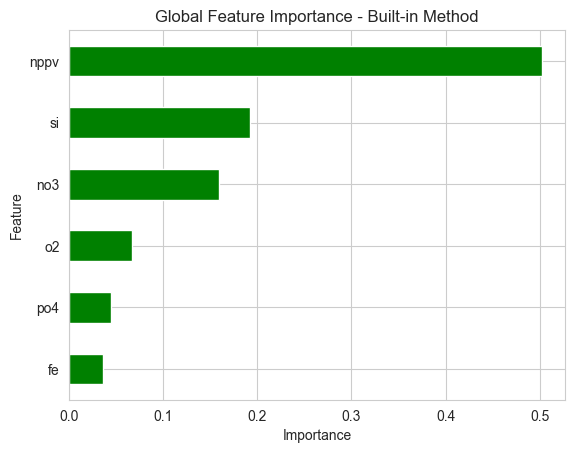

In [27]:
rf_1 = RandomForestRegressor(n_estimators=100, random_state=31)
rf_1.fit(chl_train[features], chl_train.chl)
global_importances = pd.Series(rf_1.feature_importances_, index= features)
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance - Built-in Method")

## Final cv RMSEs

In [28]:
pd.DataFrame({'Model':['Baseline (average)','Linear Regression','XgBoost','SVR','Random Forest']
              , 'cv RMSE':[base_av_rmse,m_model_lr_rmse,m_model_xg_rmse,m_model_svr_rmse,m_model_rf_rmse]
              ,'features':[features,m_model_lr,m_model_xg,m_model_svr,m_model_rf]}).style.set_caption(
                  'cv RMSE of the Models')

,Model,cv RMSE,features
0,Baseline (average),0.452944,"['fe', 'no3', 'po4', 'si', 'nppv', 'o2']"
1,Linear Regression,0.197903,"['fe', 'no3', 'po4', 'si', 'nppv', 'o2']"
2,XgBoost,0.110918,"['fe', 'no3', 'po4', 'si', 'o2']"
3,SVR,0.288208,"['fe', 'no3', 'po4', 'si']"
4,Random Forest,0.131011,"['fe', 'po4', 'si', 'o2']"
